In [1]:

from io import StringIO
import requests
import json
import pandas as pd

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_d3bd5b94a9334de59a55a7fed2bedeaa(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_adcb54bd899a7e39e31582bccad1577f68f1992f','domain': {'id': '4619da2fa8524beda11c89d2d1969c5b'},
            'password': 'P*/m8,!#7s6H9poz'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_d3bd5b94a9334de59a55a7fed2bedeaa('courseraai', 'DCOILBRENTEU.csv'))
df_data_1.head()


,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


Data Source
-----------
U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [2]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print(df_data_1.shape)

(7783, 2)


In [3]:
import matplotlib.pyplot as plt
df_data_1_plot = df_data_1.iloc[:,1:2].values.astype(float)
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

Stateful vs. Stateless LSTM
--------------------------

1. **Stateless**: LSTM updates parameters on **batch 1** and then initiates cell states (meaning - memory, usually with zeros) for **batch 2** 
2. **Stateful**: it uses batch 1 last output cell sates as initial states for batch 2.

When to use which?
----------------

- When  sequences in batches are related to each other (e.g. prices of one commodity), we should better use **stateful** mode
- Else, when one sequence represents a complete sentence, we  should go with **stateless** mode




Batch-size: which batch-size to choose?
------------------------------------

**Very important decision!**

Imagine, you must learn to recognize a bird...
You are presented images of different birds.

What would you prefer:
1. To see the one image at a time, make your notes about special bird quilities (set your **weights**) and then see another bird and so on
2. **OR** may be you would better learn if you see - let's say 5 - bird images at ones. May be then you can faster notice the bird's intrinsic properties?

I'd say - the second method is more efficient for humans. We need more examples of an entitiy, that we have to distinguish. 

**So the machines! Therefore we select a batch size of 64.
Later in programming assigment we will see how the batch size impacts the prediction accuracy.**

In [4]:
#import packages
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


In [5]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30

Batch-size and trainings-set size
-------------------------------

With **stateful LSTMs** the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)

In [6]:
length = len(df_data_1)
print(length)
length *= 1 - 0.1
print(length)


7783
7004.7


In [7]:
7004.7%64.0

28.699999999999818

In [8]:
6976.0%64.0

0.0

In [9]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [10]:
length = get_train_length(df_data_1, batch_size, 0.1)
print(length)

6912
6976
6976


In [11]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

(7036, 1)

In [12]:
# Feature Scaling
#scale between 0 and 1. the weights are esier to find.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(7036, 1)

In [13]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))
#create X_train matrix
#30 items per array (timestep) 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
#30 items per array (timestep) 
print(y_train[0:2])
print(np.array(y_train).shape)

7006
6976
6976
[array([0.07067112, 0.0693363 , 0.07007786, 0.07044865, 0.07067112,
       0.07044865, 0.07044865, 0.07030033, 0.07081943, 0.0710419 ,
       0.07156099, 0.07178346, 0.07081943, 0.07156099, 0.07178346,
       0.07178346, 0.0710419 , 0.07178346, 0.07267334, 0.07363737,
       0.07378569, 0.07378569, 0.07415647, 0.07267334, 0.07156099,
       0.07119021, 0.07400816, 0.07452725, 0.07400816, 0.07326659]), array([0.0693363 , 0.07007786, 0.07044865, 0.07067112, 0.07044865,
       0.07044865, 0.07030033, 0.07081943, 0.0710419 , 0.07156099,
       0.07178346, 0.07081943, 0.07156099, 0.07178346, 0.07178346,
       0.0710419 , 0.07178346, 0.07267334, 0.07363737, 0.07378569,
       0.07378569, 0.07415647, 0.07267334, 0.07156099, 0.07119021,
       0.07400816, 0.07452725, 0.07400816, 0.07326659, 0.07526882])]
(6976, 30)
[array([0.07526882, 0.07586207, 0.07697442, 0.07712273, 0.07697442,
       0.07845755, 0.07882833, 0.07956989, 0.07994067, 0.08290693,
       0.08379681, 0.08550241,

In [14]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)


(6976, 30, 1)
(6976, 30, 1)


In [15]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [16]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
#each layer is the input of the next layer
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [17]:
#some learners constantly reported 502 errors in Watson Studio. 
#This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))


Citation from Redwood Center for Theoretical Neuroscince (Berkeley University)
---------------------
http://redwood.berkeley.edu

http://redwood.berkeley.edu/vs265/Brian-Cheung-LSTMS.pdf

Overall LSTM Structure
----------------
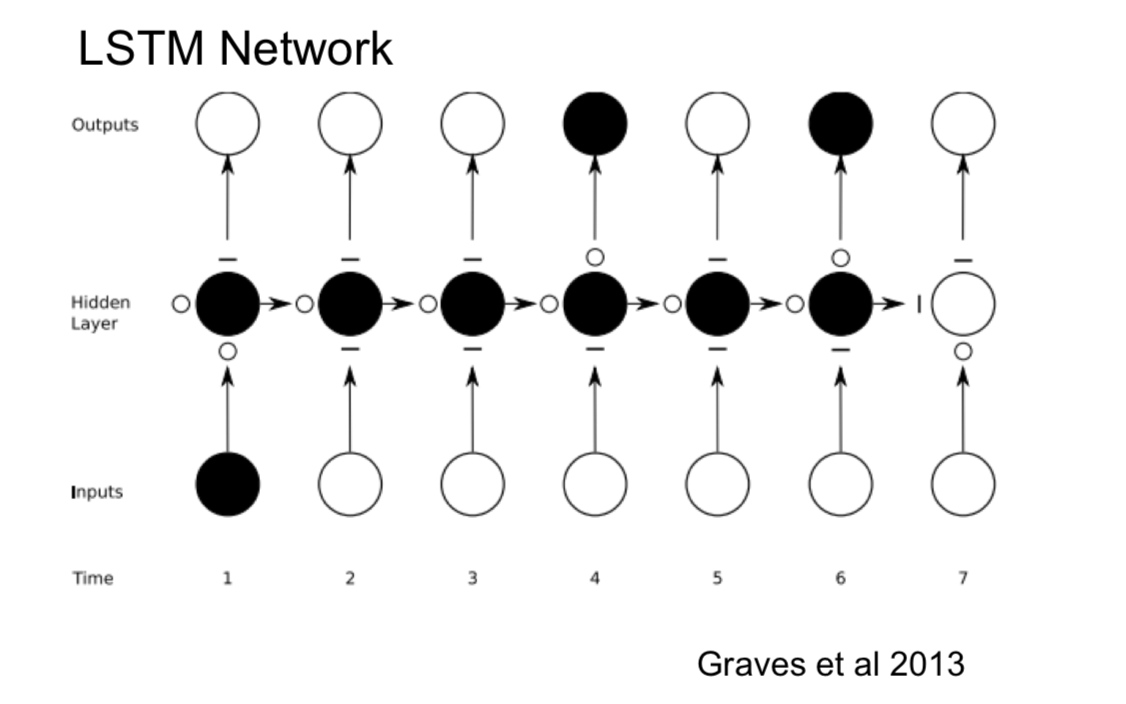


LSTM Node Anatomy
----------------
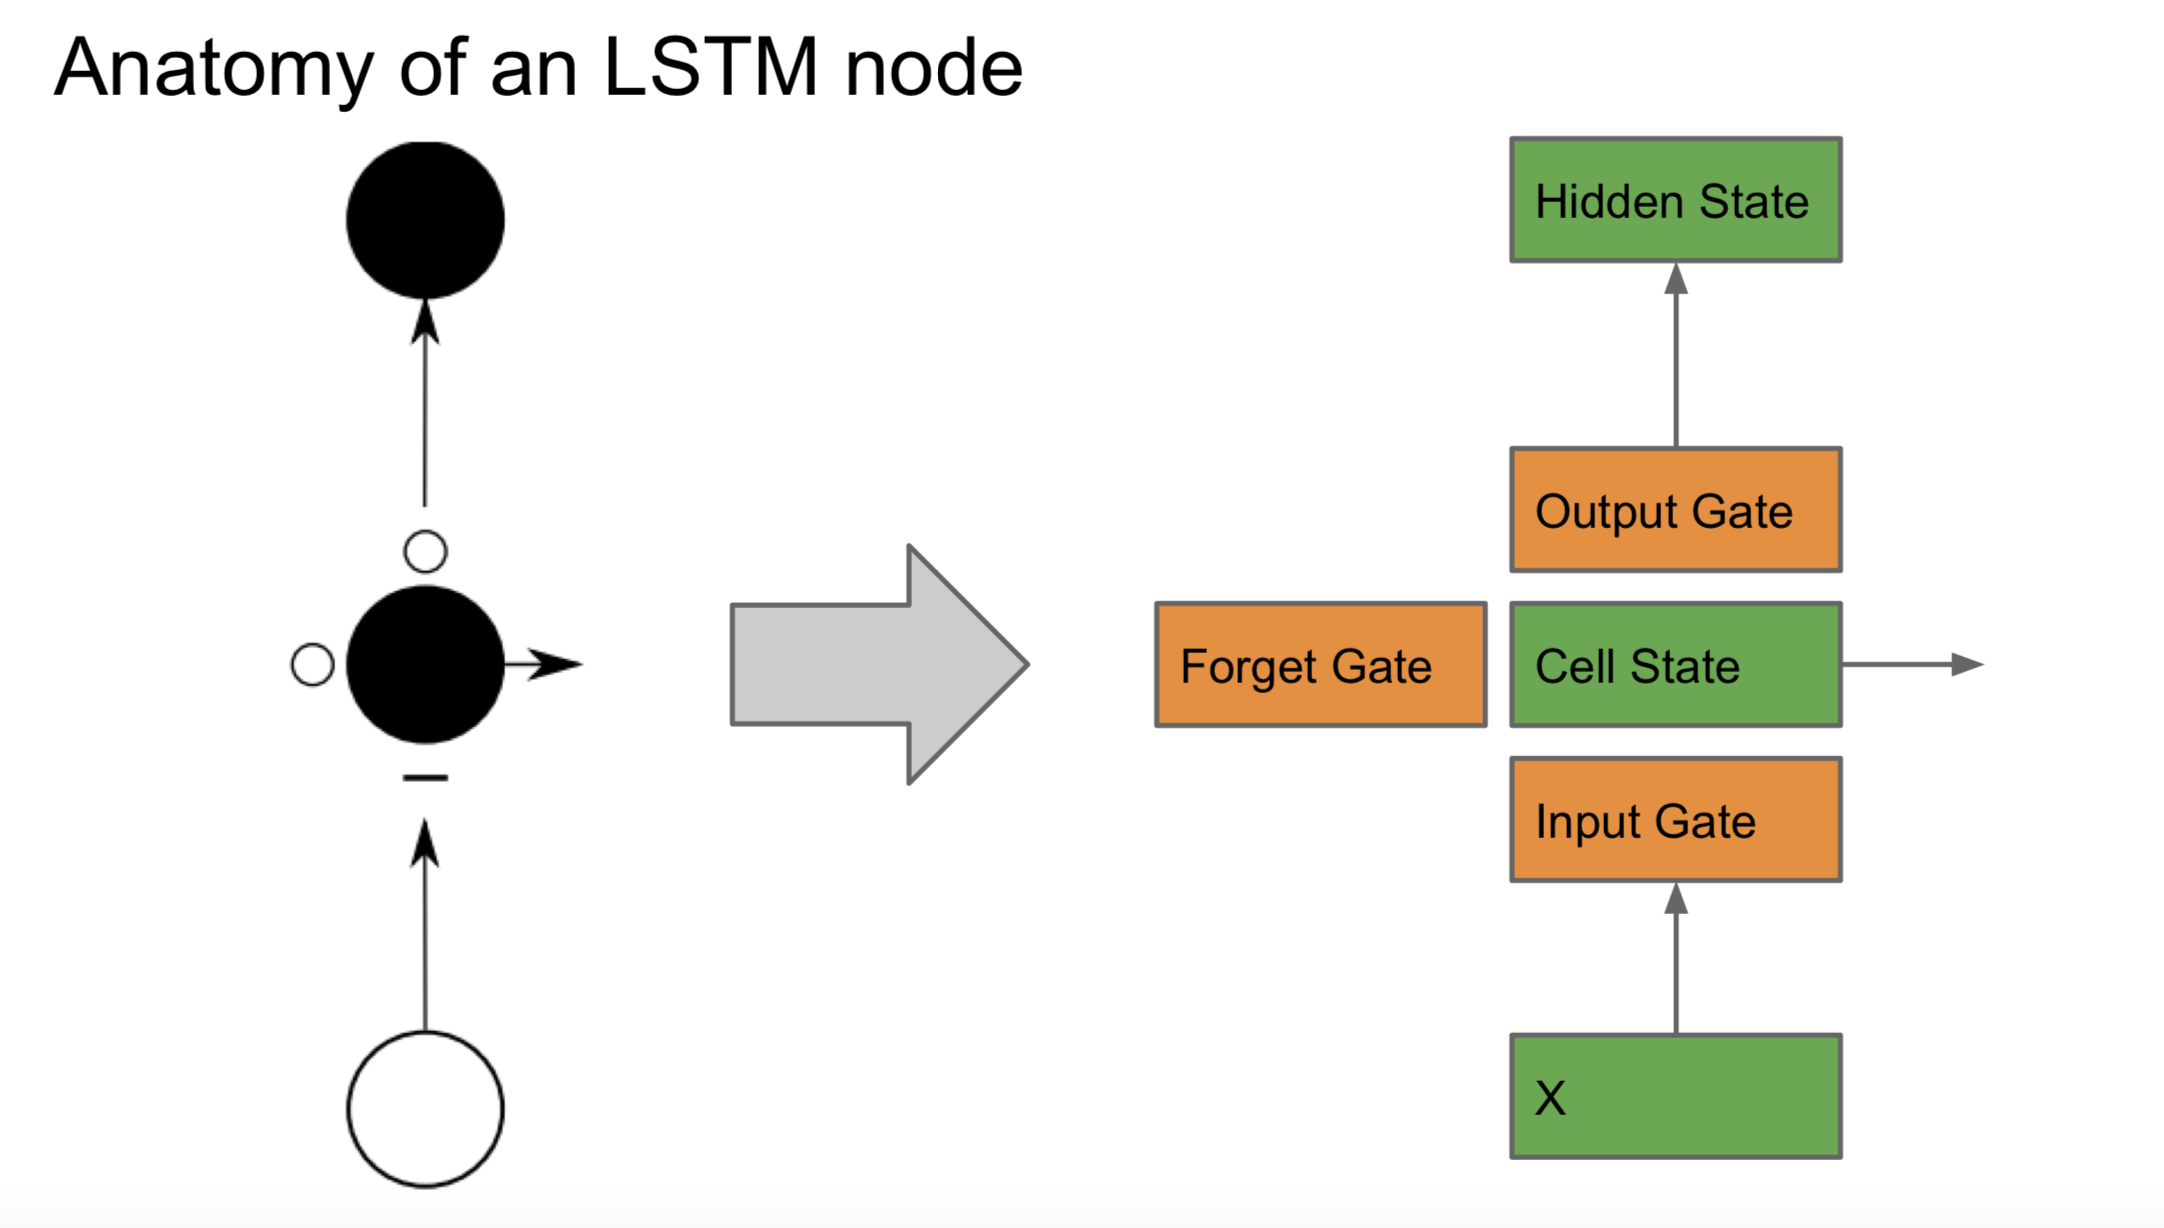

One of the best articles:
-----------------------
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

How LSTM Param Number is computed?
--------------------------------

1. To decide how to handle the memory each LSTM Cell has <bold>3 Gates</bold>: 
    - input (what to let in), 
    - forget (what to forget) and 
    - output (what to write to the output)
2. LSTM **Cell State** is its **memory**
3. LSTM Hidden State is equivalent to the Cell output:
    - lstm_hidden_state_size (number of neurons = memory cells) = lstm_outputs_size
4. Parameters:
    - weights for the inputs (lstm_inputs_size)
    - weights for the outputs (lstm_outputs_size)
    - bias variable
5.  Result from previous point - for all 3 Gates and for Cell State ( = 4)  
   
    \begin{equation}
          \textbf{PARAMETERS} = \textbf4 \times \textbf{ LSTM outputs size} \times (\textbf{weights LSTM inputs size} + \textbf{weights LSTM outputs size} + 1 \textbf{ bias variable})
    \end{equation}
    



In [18]:
# 1st LSTM Layer
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [19]:
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


In [20]:
#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

Epoch: 0
Epoch 1/1
6976/6976 [==============================] - 3s 453us/step - loss: 0.0500
Epoch: 1
Epoch 1/1
6976/6976 [==============================] - 3s 417us/step - loss: 0.0601
Epoch: 2
Epoch 1/1
6976/6976 [==============================] - 3s 385us/step - loss: 0.0565
Epoch: 3
Epoch 1/1
6976/6976 [==============================] - 3s 389us/step - loss: 0.0477
Epoch: 4
Epoch 1/1
6976/6976 [==============================] - 3s 444us/step - loss: 0.0460
Epoch: 5
Epoch 1/1
6976/6976 [==============================] - 3s 415us/step - loss: 0.0449
Epoch: 6
Epoch 1/1
6976/6976 [==============================] - 3s 433us/step - loss: 0.0439
Epoch: 7
Epoch 1/1
6976/6976 [==============================] - 3s 396us/step - loss: 0.0429
Epoch: 8
Epoch 1/1
6976/6976 [==============================] - 3s 393us/step - loss: 0.0422
Epoch: 9
Epoch 1/1
6976/6976 [==============================] - 3s 386us/step - loss: 0.0418
Epoch: 10
Epoch 1/1
6976/6976 [==============================] - 3s 44

6976/6976 [==============================] - 5s 687us/step - loss: 0.0339
Epoch: 88
Epoch 1/1
6976/6976 [==============================] - 4s 517us/step - loss: 0.0338 0s - l
Epoch: 89
Epoch 1/1
6976/6976 [==============================] - 4s 590us/step - loss: 0.0338
Epoch: 90
Epoch 1/1
6976/6976 [==============================] - 4s 543us/step - loss: 0.0338
Epoch: 91
Epoch 1/1
6976/6976 [==============================] - 4s 570us/step - loss: 0.0337
Epoch: 92
Epoch 1/1
6976/6976 [==============================] - 4s 540us/step - loss: 0.0337
Epoch: 93
Epoch 1/1
6976/6976 [==============================] - 5s 726us/step - loss: 0.0336
Epoch: 94
Epoch 1/1
6976/6976 [==============================] - 4s 637us/step - loss: 0.0337
Epoch: 95
Epoch 1/1
6976/6976 [==============================] - 4s 614us/step - loss: 0.0336
Epoch: 96
Epoch 1/1
6976/6976 [==============================] - 4s 502us/step - loss: 0.0336
Epoch: 97
Epoch 1/1
6976/6976 [==============================] - 3s 466us

In [21]:
#save model
import h5py
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")

In [23]:
#load model
import h5py
regressor_mae = load_model(filepath="my_model_with_mae_30_ts.h5")

In [24]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [25]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

7612
7676
7676
640


In [26]:
print(upper_train, upper_test, len(df_data_1))

7036 7736 7783


In [28]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [29]:
X_test.shape

(640, 30, 1)

In [30]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(640, 30, 1)
(640, 30)
(610, 1)


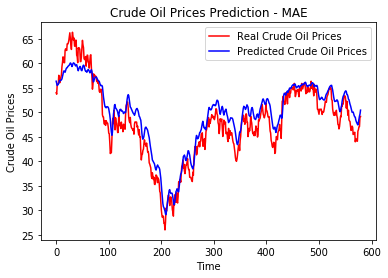

In [31]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [32]:
#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

2.8968079283804906


In [33]:
#MAE (mean absolut error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

2.4658096809387207


In [34]:
# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

#mse -> mean squared error as loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_3 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_4 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_2 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [35]:
#some learners constantly reported 502 errors in Watson Studio. 
#This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))


In [36]:
epochs = 120
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mse.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse.reset_states()

Epoch: 0
Epoch 1/1
6976/6976 [==============================] - 4s 578us/step - loss: 0.0057
Epoch: 1
Epoch 1/1
6976/6976 [==============================] - 3s 392us/step - loss: 0.0060
Epoch: 2
Epoch 1/1
6976/6976 [==============================] - 4s 585us/step - loss: 0.0049
Epoch: 3
Epoch 1/1
6976/6976 [==============================] - 8s 1ms/step - loss: 0.0044
Epoch: 4
Epoch 1/1
6976/6976 [==============================] - 9s 1ms/step - loss: 0.0041
Epoch: 5
Epoch 1/1
6976/6976 [==============================] - 9s 1ms/step - loss: 0.0040
Epoch: 6
Epoch 1/1
6976/6976 [==============================] - 6s 915us/step - loss: 0.0039
Epoch: 7
Epoch 1/1
6976/6976 [==============================] - 4s 625us/step - loss: 0.0038
Epoch: 8
Epoch 1/1
6976/6976 [==============================] - 4s 544us/step - loss: 0.0038
Epoch: 9
Epoch 1/1
6976/6976 [==============================] - 5s 743us/step - loss: 0.0037
Epoch: 10
Epoch 1/1
6976/6976 [==============================] - 5s 706us/st

6976/6976 [==============================] - 4s 571us/step - loss: 0.0027
Epoch: 87
Epoch 1/1
6976/6976 [==============================] - 5s 683us/step - loss: 0.0028
Epoch: 88
Epoch 1/1
6976/6976 [==============================] - 4s 564us/step - loss: 0.0028
Epoch: 89
Epoch 1/1
6976/6976 [==============================] - 4s 556us/step - loss: 0.0028
Epoch: 90
Epoch 1/1
6976/6976 [==============================] - 4s 554us/step - loss: 0.0026
Epoch: 91
Epoch 1/1
6976/6976 [==============================] - 4s 615us/step - loss: 0.0025
Epoch: 92
Epoch 1/1
6976/6976 [==============================] - 4s 565us/step - loss: 0.0025
Epoch: 93
Epoch 1/1
6976/6976 [==============================] - 3s 468us/step - loss: 0.0027
Epoch: 94
Epoch 1/1
6976/6976 [==============================] - 3s 436us/step - loss: 0.0031
Epoch: 95
Epoch 1/1
6976/6976 [==============================] - 4s 519us/step - loss: 0.0032
Epoch: 96
Epoch 1/1
6976/6976 [==============================] - 3s 467us/step -

In [37]:
import h5py
regressor_mse.save(filepath="my_model_with_mse_30_ts.h5")

In [38]:
regressor_mse = load_model(filepath="my_model_with_mse_30_ts.h5")

In [39]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

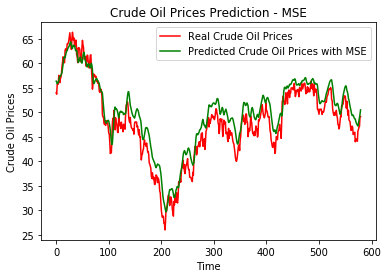

In [40]:
# Visualising the results
plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'green', label = 'Predicted Crude Oil Prices with MSE')
plt.title('Crude Oil Prices Prediction - MSE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print(rmse)

2.7845340781615557


In [42]:
mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print(mean)

48.153965517241375


In [43]:
rmse/mean * 100

5.782564422787906

In [44]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print(mae)

2.382008031253157


In [45]:
mae/mean * 100

4.946649784014748

In [47]:
#!pwd
#!ls *.h5